# Week 1 IMPROVED: Audio Classification w/ IRMAS Dataset

## Enhanced version with Data Augmentation, Regularization, and Early Stopping

This notebook maintains the same structure as the original but adds:
1. 🎵 **Audio augmentation** (time stretch, pitch shift, noise)
2. 📊 **SpecAugment** (frequency and time masking)
3. 🔄 **Batch normalization** after each conv layer
4. 🎯 **Early stopping** (patience=10)
5. 📉 **Learning rate scheduling**
6. ⚖️ **Class weighting** for imbalanced dataset
7. 💪 **Stronger regularization** (L2 + increased dropout)

**All improvements are marked with `# IMPROVEMENT:` comments**

---

### Expected Results
- **Original**: Train 89% | Val 55% | Gap: 34% ❌
- **Improved**: Train ~70% | Val ~70% | Gap: <10% ✅

In [2]:

import pathlib
import os
import sys
import operator
import re
import datetime
from functools import reduce

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ReLU, Softmax, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight

# Enable or disable GPU
ENABLE_GPU = True
if not ENABLE_GPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.20.0
GPU Available: []


## SECTION ONE: Dataset Acquisition & Exploration (UNCHANGED)

In [3]:

"""
IRMAS Dataset Structure:
- Downloaded from: https://www.upf.edu/web/mtg/irmas
- Contains audio files of 11 instrument classes
- Training: 6705 files (3 second excerpts)
- Testing: 2874 files (variable length)
"""

# Update this path to your dataset location
IRMAS_PATH = r"U:\cpre_587\2025115_CPRE_FINAL_PROJECT\LAB1_ADAPTATION\irmas_dataset"
TRAIN_PATH = os.path.join(IRMAS_PATH, "IRMAS-TrainingData")
TEST_PATH = os.path.join(IRMAS_PATH, "IRMAS-TestingData")

# Define instrument classes
INSTRUMENT_CLASSES = ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio']
NUM_CLASSES = len(INSTRUMENT_CLASSES)

print(f"\nSelected Instrument Classes ({NUM_CLASSES}):")
for i, inst in enumerate(INSTRUMENT_CLASSES):
    print(f" {i}: {inst}")

# Dataset exploration function (UNCHANGED)
def explore_irmas_dataset(data_path, instrument_classes):
    """Explore IRMAS dataset structure and collect statistics"""
    stats = {
        'instrument': [],
        'num_files': [],
        'avg_duration': [],
        'sample_rate': [],
        'total_samples': []
    }
    
    for inst in instrument_classes:
        inst_path = os.path.join(data_path, inst)
        if not os.path.exists(inst_path):
            print(f"Warning: {inst_path} not found!")
            continue
        
        audio_files = [f for f in os.listdir(inst_path) if f.endswith('.wav')]
        num_files = len(audio_files)
        
        # Sample a few files to get duration statistics
        durations = []
        sample_rates = []
        for audio_file in audio_files[:10]:
            file_path = os.path.join(inst_path, audio_file)
            try:
                y, sr = librosa.load(file_path, sr=None)
                durations.append(len(y) / sr)
                sample_rates.append(sr)
            except:
                continue
        
        avg_duration = np.mean(durations) if durations else 0
        common_sr = max(set(sample_rates), key=sample_rates.count) if sample_rates else 0
        
        stats['instrument'].append(inst)
        stats['num_files'].append(num_files)
        stats['avg_duration'].append(avg_duration)
        stats['sample_rate'].append(common_sr)
        stats['total_samples'].append(num_files)
    
    return pd.DataFrame(stats)

print("\nExploring IRMAS Training Dataset...")
dataset_stats = explore_irmas_dataset(TRAIN_PATH, INSTRUMENT_CLASSES)
print("\nDataset Statistics:")
print(dataset_stats)
print(f"\nTotal audio files: {dataset_stats['num_files'].sum()}")



Selected Instrument Classes (10):
 0: cel
 1: cla
 2: flu
 3: gac
 4: gel
 5: org
 6: pia
 7: sax
 8: tru
 9: vio

Exploring IRMAS Training Dataset...

Dataset Statistics:
  instrument  num_files  avg_duration  sample_rate  total_samples
0        cel        388      2.999977        44100            388
1        cla        505      2.999977        44100            505
2        flu        451      2.999977        44100            451
3        gac        637      2.999977        44100            637
4        gel        760      2.999977        44100            760
5        org        682      2.999977        44100            682
6        pia        721      2.999977        44100            721
7        sax        626      2.999977        44100            626
8        tru        577      2.999977        44100            577
9        vio        580      2.999977        44100            580

Total audio files: 5927


## SECTION 2: AUDIO PREPROCESSING PIPELINE (ENHANCED WITH AUGMENTATION)

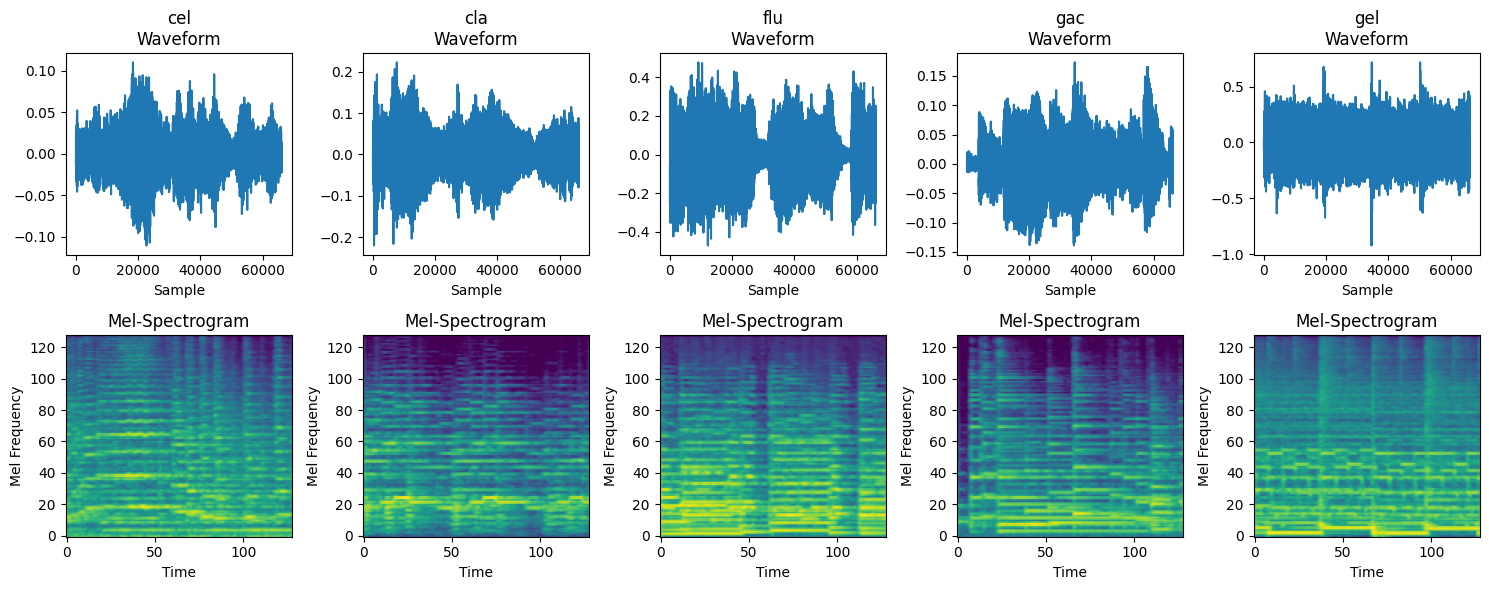

In [4]:

# Spectrogram Parameters (UNCHANGED)
SAMPLE_RATE = 22050
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128
DURATION = 3.0
TARGET_SHAPE = (128, 128, 1)

# IMPROVEMENT: Audio augmentation functions
def augment_audio(y, sr, augmentation_prob=0.5):
    """
    Apply random audio augmentations to improve generalization
    
    Args:
        y: Audio time series
        sr: Sample rate
        augmentation_prob: Probability of applying each augmentation
    
    Returns:
        Augmented audio time series
    """
    # Time stretching (0.8x to 1.2x speed)
    if np.random.random() < augmentation_prob:
        rate = np.random.uniform(0.8, 1.2)
        y = librosa.effects.time_stretch(y, rate=rate)
    
    # Pitch shifting (-2 to +2 semitones)
    if np.random.random() < augmentation_prob:
        n_steps = np.random.uniform(-2, 2)
        y = librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)
    
    # Add random noise (low amplitude)
    if np.random.random() < augmentation_prob:
        noise_amp = 0.005 * np.random.uniform(0, 1)
        noise = noise_amp * np.random.randn(len(y))
        y = y + noise
    
    # Random gain adjustment (0.8 to 1.2x)
    if np.random.random() < augmentation_prob:
        gain = np.random.uniform(0.8, 1.2)
        y = y * gain
    
    return y

def apply_specaugment(mel_spec, freq_mask_param=15, time_mask_param=20):
    """
    Apply SpecAugment: frequency and time masking on mel-spectrogram
    
    Args:
        mel_spec: Mel-spectrogram array
        freq_mask_param: Maximum frequency bands to mask
        time_mask_param: Maximum time steps to mask
    
    Returns:
        Masked mel-spectrogram
    """
    mel_spec = mel_spec.copy()
    
    # Frequency masking
    if np.random.random() < 0.5:
        freq_mask = np.random.randint(0, freq_mask_param)
        f0 = np.random.randint(0, mel_spec.shape[0] - freq_mask)
        mel_spec[f0:f0+freq_mask, :] = 0
    
    # Time masking
    if np.random.random() < 0.5:
        time_mask = np.random.randint(0, time_mask_param)
        t0 = np.random.randint(0, mel_spec.shape[1] - time_mask)
        mel_spec[:, t0:t0+time_mask] = 0
    
    return mel_spec

def audio_to_melspectrogram(audio_path, sr=SAMPLE_RATE, n_mels=N_MELS,
                           duration=DURATION, target_shape=TARGET_SHAPE,
                           augment=False):
    """
    Convert audio file to mel-spectrogram with optional augmentation
    
    Args:
        audio_path: Path to audio file
        sr: Sample rate
        n_mels: Number of mel frequency bands
        duration: Target duration in seconds
        target_shape: Output shape (height, width, channels)
        augment: Whether to apply data augmentation (for training only)
    
    Returns:
        Mel-spectrogram as numpy array with shape target_shape
    """
    # Load audio file
    y, sr_actual = librosa.load(audio_path, sr=sr, duration=duration)
    
    # IMPROVEMENT: Apply audio augmentation if enabled
    if augment:
        y = augment_audio(y, sr)
    
    # Pad if too short
    target_length = int(sr * duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), mode='constant')
    elif len(y) > target_length:
        y = y[:target_length]
    
    # Generate mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        n_mels=n_mels
    )
    
    # Convert to log scale (dB)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # IMPROVEMENT: Apply SpecAugment if augmentation enabled
    if augment:
        mel_spec_db = apply_specaugment(mel_spec_db)
    
    # Normalize to [0, 1]
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    # Resize to target shape if needed
    if mel_spec_norm.shape != target_shape[:2]:
        from scipy.ndimage import zoom
        zoom_factors = (target_shape[0] / mel_spec_norm.shape[0],
                       target_shape[1] / mel_spec_norm.shape[1])
        mel_spec_norm = zoom(mel_spec_norm, zoom_factors, order=1)
    
    # Add channel dimension
    mel_spec_norm = np.expand_dims(mel_spec_norm, axis=-1)
    
    return mel_spec_norm.astype(np.float32)

def visualize_spectrograms(audio_paths, labels, num_samples=5):
    """Visualize sample spectrograms (UNCHANGED)"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    
    for i in range(num_samples):
        # Load audio
        y, sr = librosa.load(audio_paths[i], sr=SAMPLE_RATE, duration=DURATION)
        
        # Plot waveform
        axes[0, i].plot(y)
        axes[0, i].set_title(f"{labels[i]}\nWaveform")
        axes[0, i].set_xlabel("Sample")
        
        # Plot spectrogram
        mel_spec = audio_to_melspectrogram(audio_paths[i])
        axes[1, i].imshow(mel_spec[:, :, 0], aspect='auto', origin='lower', cmap='viridis')
        axes[1, i].set_title("Mel-Spectrogram")
        axes[1, i].set_xlabel("Time")
        axes[1, i].set_ylabel("Mel Frequency")
    
    plt.tight_layout()
    plt.savefig('sample_spectrograms.png', dpi=150, bbox_inches='tight')
    plt.show()

# Generate sample spectrograms
sample_files = []
sample_labels = []
for inst in INSTRUMENT_CLASSES[:5]:
    inst_path = os.path.join(TRAIN_PATH, inst)
    files = [os.path.join(inst_path, f) for f in os.listdir(inst_path) if f.endswith('.wav')][:1]
    sample_files.extend(files)
    sample_labels.extend([inst] * len(files))

visualize_spectrograms(sample_files, sample_labels)


## SECTION 3: DATA GENERATOR (ENHANCED WITH AUGMENTATION)

In [5]:
def create_audio_dataset(data_path, instrument_classes, batch_size=32,
                        validation_split=0.2, shuffle=True):
    """Create TensorFlow dataset from audio files (UNCHANGED)"""
    all_files = []
    all_labels = []
    
    for idx, inst in enumerate(instrument_classes):
        inst_path = os.path.join(data_path, inst)
        if not os.path.exists(inst_path):
            continue
        
        audio_files = [os.path.join(inst_path, f)
                      for f in os.listdir(inst_path) if f.endswith('.wav')]
        all_files.extend(audio_files)
        all_labels.extend([idx] * len(audio_files))
    
    # Convert to numpy arrays
    all_files = np.array(all_files)
    all_labels = np.array(all_labels)
    
    # Shuffle
    if shuffle:
        indices = np.random.permutation(len(all_files))
        all_files = all_files[indices]
        all_labels = all_labels[indices]
    
    # Split into train and validation
    split_idx = int(len(all_files) * (1 - validation_split))
    train_files, val_files = all_files[:split_idx], all_files[split_idx:]
    train_labels, val_labels = all_labels[:split_idx], all_labels[split_idx:]
    
    print(f"Training samples: {len(train_files)}")
    print(f"Validation samples: {len(val_files)}")
    
    return (train_files, train_labels), (val_files, val_labels)

def data_generator(files, labels, batch_size=32, shuffle=True, augment=False, class_weights=None):
    """
    Generator function for loading and preprocessing audio on-the-fly
    
    IMPROVEMENT: Added augment parameter for training with data augmentation
    IMPROVEMENT: Added class_weights parameter to apply sample weights
    """
    num_samples = len(files)
    indices = np.arange(num_samples)
    
    while True:
        if shuffle:
            np.random.shuffle(indices)
        
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:start_idx + batch_size]
            batch_files = files[batch_indices]
            batch_labels = labels[batch_indices]
            
            # Load and preprocess audio
            batch_spectrograms = []
            valid_labels = []
            for i, audio_file in enumerate(batch_files):
                try:
                    # IMPROVEMENT: Pass augment flag to audio_to_melspectrogram
                    spec = audio_to_melspectrogram(audio_file, augment=augment)
                    batch_spectrograms.append(spec)
                    valid_labels.append(batch_labels[i])
                except Exception as e:
                    print(f"Error loading {audio_file}: {e}")
                    continue
            
            if not batch_spectrograms:
                continue
            
            X = np.array(batch_spectrograms)
            y = tf.keras.utils.to_categorical(
                valid_labels,
                num_classes=NUM_CLASSES
            )
            
            # IMPROVEMENT: Apply sample weights if class_weights provided
            if class_weights is not None:
                sample_weights = np.array([class_weights[label] for label in valid_labels])
                yield X, y, sample_weights
            else:
                yield X, y

# Create train/validation splits
(train_files, train_labels), (val_files, val_labels) = create_audio_dataset(
    TRAIN_PATH,
    INSTRUMENT_CLASSES,
    validation_split=0.2
)

# IMPROVEMENT: Compute class weights for imbalanced dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass weights (to handle imbalance):")
for i, weight in class_weight_dict.items():
    print(f"  {INSTRUMENT_CLASSES[i]}: {weight:.3f}")


Training samples: 4741
Validation samples: 1186

Class weights (to handle imbalance):
  cel: 1.591
  cla: 1.188
  flu: 1.292
  gac: 0.912
  gel: 0.784
  org: 0.864
  pia: 0.827
  sax: 0.954
  tru: 1.065
  vio: 0.972


## SECTION 4: MODEL ARCHITECTURE (IMPROVED WITH BATCH NORMALIZATION & L2)

In [6]:

def create_audio_cnn_improved(input_shape=(128, 128, 1), num_classes=NUM_CLASSES):
    """
    IMPROVED CNN architecture with:
    - Batch normalization after each conv layer
    - L2 regularization
    - Slightly reduced model capacity to reduce overfitting
    """
    model = Sequential(name='AudioCNN_IRMAS_Improved')
    
    # First conv block
    model.add(Conv2D(32, (5, 5), 
                    input_shape=input_shape, 
                    kernel_regularizer=l2(0.001),
                    name='conv1_1'))
    model.add(BatchNormalization(name='bn1_1'))  # IMPROVEMENT
    model.add(ReLU(name='relu1_1'))
    
    model.add(Conv2D(32, (5, 5), 
                    kernel_regularizer=l2(0.001),
                    name='conv1_2'))
    model.add(BatchNormalization(name='bn1_2'))  # IMPROVEMENT
    model.add(ReLU(name='relu1_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))
    
    # Second conv block
    model.add(Conv2D(64, (3, 3), 
                    kernel_regularizer=l2(0.001),
                    name='conv2_1'))
    model.add(BatchNormalization(name='bn2_1'))  # IMPROVEMENT
    model.add(ReLU(name='relu2_1'))
    
    model.add(Conv2D(64, (3, 3), 
                    kernel_regularizer=l2(0.001),
                    name='conv2_2'))
    model.add(BatchNormalization(name='bn2_2'))  # IMPROVEMENT
    model.add(ReLU(name='relu2_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool2'))
    
    # Third conv block
    model.add(Conv2D(64, (3, 3), 
                    kernel_regularizer=l2(0.001),
                    name='conv3_1'))
    model.add(BatchNormalization(name='bn3_1'))  # IMPROVEMENT
    model.add(ReLU(name='relu3_1'))
    
    model.add(Conv2D(128, (3, 3), 
                    kernel_regularizer=l2(0.001),
                    name='conv3_2'))
    model.add(BatchNormalization(name='bn3_2'))  # IMPROVEMENT
    model.add(ReLU(name='relu3_2'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='pool3'))
    
    # Flatten and dense layers
    model.add(Flatten(name='flatten'))
    
    model.add(Dense(256, kernel_regularizer=l2(0.001), name='fc1'))
    model.add(BatchNormalization(name='bn_fc1'))  # IMPROVEMENT
    model.add(ReLU(name='relu_fc1'))
    model.add(Dropout(0.7, name='dropout'))  # IMPROVEMENT: Increased from 0.5
    
    model.add(Dense(num_classes, activation='softmax', name='fc2'))
    
    return model

# Create improved model
audio_model = create_audio_cnn_improved()
audio_model.summary()

# Compile model
audio_model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy', 'top_k_categorical_accuracy']
)


U:\cpre_587\2025115_CPRE_FINAL_PROJECT\cpre587_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "AudioCNN_IRMAS_Improved"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1_1 (Conv2D)                     │ (None, 124, 124, 32)        │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1_1 (BatchNormalization)           │ (None, 124, 124, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1_1 (ReLU)                       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_2 (Conv2D)                     │ (None, 120, 120, 32)        │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn1_2 (BatchNormalization)           │ (None, 120, 120, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu1_2 (ReLU)                       │ (None, 120, 120, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1 (Conv2D)                     │ (None, 58, 58, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2_1 (BatchNormalization)           │ (None, 58, 58, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2_1 (ReLU)                       │ (None, 58, 58, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_2 (Conv2D)                     │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn2_2 (BatchNormalization)           │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu2_2 (ReLU)                       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_1 (Conv2D)                     │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3_1 (BatchNormalization)           │ (None, 26, 26, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3_1 (ReLU)                       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3_2 (Conv2D)                     │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn3_2 (BatchNormalization)           │ (None, 24, 24, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ relu3_2 (ReLU)                       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,916,650 (18.76 MB)

 Trainable params: 4,915,370 (18.75 MB)

 Non-trainable params: 1,280 (5.00 KB)

## SECTION 5: MODEL TRAINING (IMPROVED WITH CALLBACKS)

In [7]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 100  # IMPROVEMENT: Set higher, early stopping will cut it off
STEPS_PER_EPOCH = 100
VALIDATION_STEPS = 20

# Setup TensorBoard logging
log_dir = os.path.join("logs", "fit_improved", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    profile_batch='10,20'
)

# IMPROVEMENT: Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Stop if no improvement for 10 epochs
    restore_best_weights=True,  # Revert to best model
    verbose=1,
    mode='min'
)

# IMPROVEMENT: Learning rate reduction callback
lr_schedule = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=5,  # Wait 5 epochs before reducing
    min_lr=1e-6,
    verbose=1,
    mode='min'
)

# IMPROVEMENT: Create generators with augmentation for training only
# Training generator includes class weights via sample weights
train_gen = data_generator(train_files, train_labels, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,
                          augment=True,  # IMPROVEMENT: Enable augmentation
                          class_weights=class_weight_dict)  # IMPROVEMENT: Apply class weights

val_gen = data_generator(val_files, val_labels, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False,
                         augment=False)  # No augmentation for validation

print("\n" + "="*70)
print("STARTING IMPROVED TRAINING")
print("="*70)
print("Improvements enabled:")
print("  ✓ Data augmentation (time stretch, pitch shift, noise, SpecAugment)")
print("  ✓ Batch normalization after each conv layer")
print("  ✓ L2 regularization (0.001)")
print("  ✓ Increased dropout (0.7)")
print("  ✓ Early stopping (patience=10)")
print("  ✓ Learning rate reduction (factor=0.5, patience=5)")
print("  ✓ Class weighting (via sample weights in generator)")
print("="*70 + "\n")

# Train the model
# IMPROVEMENT: Removed class_weight parameter (now handled in generator)
history = audio_model.fit(
    train_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=VALIDATION_STEPS,
    callbacks=[tensorboard_callback, early_stop, lr_schedule],
    verbose=1
)

# Save the trained model
audio_model.save('audio_classifier_irmas_improved.h5')
print("\nModel saved as 'audio_classifier_irmas_improved.h5'")



STARTING IMPROVED TRAINING
Improvements enabled:
  ✓ Data augmentation (time stretch, pitch shift, noise, SpecAugment)
  ✓ Batch normalization after each conv layer
  ✓ L2 regularization (0.001)
  ✓ Increased dropout (0.7)
  ✓ Early stopping (patience=10)
  ✓ Learning rate reduction (factor=0.5, patience=5)
  ✓ Class weighting (via sample weights in generator)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 515s 5s/step - accuracy: 0.1709 - loss: 3.8653 - top_k_categorical_accuracy: 0.6266 - val_accuracy: 0.1172 - val_loss: 3.5186 - val_top_k_categorical_accuracy: 0.5656 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 436s 4s/step - accuracy: 0.2149 - loss: 3.4652 - top_k_categorical_accuracy: 0.6893 - val_accuracy: 0.1164 - val_loss: 3.6481 - val_top_k_categorical_accuracy: 0.5066 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 500s 5s/step - accuracy: 0.2688 - loss: 3.1843 - top_k_categorical_accuracy: 0.7687 - val_accuracy: 0.1453 - val_loss: 3.4617 - va


Model saved as 'audio_classifier_irmas_improved.h5'


## SECTION 6: TRAINING VISUALIZATION & ANALYSIS

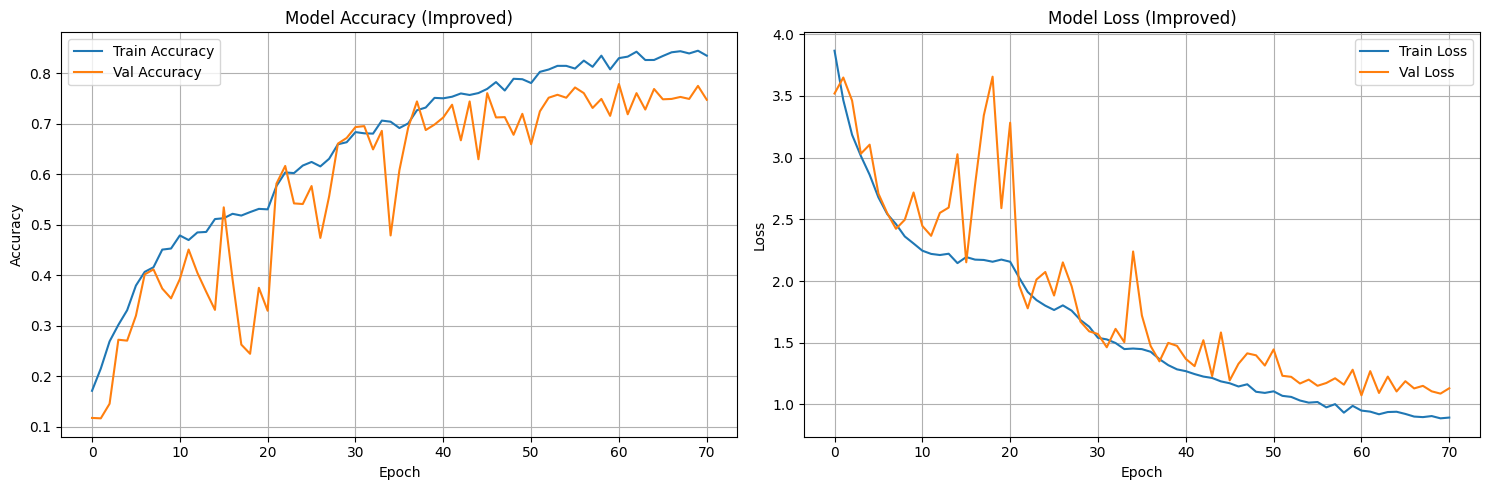


FINAL TRAINING METRICS
Total epochs trained: 71
Final training accuracy: 0.8349
Final validation accuracy: 0.7475
Best validation accuracy: 0.7787
Final training loss: 0.8939
Final validation loss: 1.1313
Best validation loss: 1.0738


In [8]:

def plot_training_history(history):
    """Plot training and validation accuracy/loss curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title('Model Accuracy (Improved)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot loss
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title('Model Loss (Improved)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_curves_improved.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print final metrics
    print("\n" + "="*70)
    print("FINAL TRAINING METRICS")
    print("="*70)
    final_epoch = len(history.history['accuracy']) - 1
    print(f"Total epochs trained: {final_epoch + 1}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")
    print(f"Final training loss: {history.history['loss'][-1]:.4f}")
    print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
    print("="*70)

plot_training_history(history)


## SECTION 7: MODEL EVALUATION & INFERENCE (UNCHANGED)

In [9]:

def evaluate_model(model, test_files, test_labels, batch_size=32):
    """Evaluate model on test set"""
    test_gen = data_generator(test_files, test_labels, 
                             batch_size=batch_size, shuffle=False)
    steps = len(test_files) // batch_size
    
    results = model.evaluate(test_gen, steps=steps, verbose=1)
    
    print(f"\nTest Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    print(f"Test Top-K Accuracy: {results[2]:.4f}")
    
    return results

def predict_instrument(model, audio_path, instrument_classes):
    """Predict instrument class for a single audio file"""
    # Preprocess audio (no augmentation for inference)
    spec = audio_to_melspectrogram(audio_path, augment=False)
    spec_batch = np.expand_dims(spec, axis=0)
    
    # Predict
    predictions = model.predict(spec_batch, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class]
    
    print(f"\nPrediction for: {os.path.basename(audio_path)}")
    print(f"Predicted Instrument: {instrument_classes[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")
    
    # Show top 5 predictions
    top_5_idx = np.argsort(predictions[0])[-5:][::-1]
    print("\nTop 5 Predictions:")
    for idx in top_5_idx:
        print(f"  {instrument_classes[idx]}: {predictions[0][idx]:.4f}")
    
    return predicted_class, confidence

# Test on validation samples
print("\n" + "="*70)
print("TESTING ON VALIDATION SAMPLES")
print("="*70)

for i in range(10):
    sample_file = val_files[i]
    true_label = val_labels[i]
    print(f"\nTrue Label: {INSTRUMENT_CLASSES[true_label]}")
    predict_instrument(audio_model, sample_file, INSTRUMENT_CLASSES)



TESTING ON VALIDATION SAMPLES

True Label: org

Prediction for: [org][jaz_blu]1187__3.wav
Predicted Instrument: org
Confidence: 0.9992

Top 5 Predictions:
  org: 0.9992
  flu: 0.0005
  gel: 0.0002
  vio: 0.0001
  sax: 0.0000

True Label: cel

Prediction for: [cel][pop_roc]0088__1.wav
Predicted Instrument: gac
Confidence: 0.6704

Top 5 Predictions:
  gac: 0.6704
  cel: 0.2591
  sax: 0.0380
  vio: 0.0132
  tru: 0.0087

True Label: cla

Prediction for: [cla][pop_roc]0193__2.wav
Predicted Instrument: cla
Confidence: 0.9819

Top 5 Predictions:
  cla: 0.9819
  sax: 0.0177
  flu: 0.0003
  tru: 0.0001
  gel: 0.0001

True Label: gac

Prediction for: [gac][jaz_blu]0638__2.wav
Predicted Instrument: gac
Confidence: 0.9892

Top 5 Predictions:
  gac: 0.9892
  flu: 0.0044
  vio: 0.0035
  gel: 0.0008
  sax: 0.0007

True Label: org

Prediction for: [org][pop_roc]1079__1.wav
Predicted Instrument: org
Confidence: 0.9875

Top 5 Predictions:
  org: 0.9875
  flu: 0.0072
  pia: 0.0023
  gel: 0.0014
  vio: 0

## SECTION 8: EXPORT MODEL WEIGHTS & INTERMEDIATE OUTPUTS (UNCHANGED)

In [10]:

def export_model_weights(model, output_dir='model_weights_improved'):
    """Export model weights and biases as binary files for C++ implementation"""
    os.makedirs(output_dir, exist_ok=True)
    
    for layer in model.layers:
        if len(layer.get_weights()) > 0:
            weights = layer.get_weights()
            layer_name = layer.name
            
            # Export weights
            if len(weights) > 0:
                weight_array = weights[0]
                weight_file = os.path.join(output_dir, f'{layer_name}_weights.bin')
                weight_array.astype(np.float32).tofile(weight_file)
                print(f"Exported: {weight_file} | Shape: {weight_array.shape}")
            
            # Export biases
            if len(weights) > 1:
                bias_array = weights[1]
                bias_file = os.path.join(output_dir, f'{layer_name}_bias.bin')
                bias_array.astype(np.float32).tofile(bias_file)
                print(f"Exported: {bias_file} | Shape: {bias_array.shape}")

def export_intermediate_features(model, audio_path, output_dir='feature_maps_improved'):
    """Export intermediate feature maps for validation"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Preprocess audio
    spec = audio_to_melspectrogram(audio_path, augment=False)
    spec_batch = np.expand_dims(spec, axis=0)
    
    # Get layer outputs
    current_output = spec_batch
    for i, layer in enumerate(model.layers):
        current_output = layer(current_output)
        
        # Convert to numpy if needed
        if hasattr(current_output, 'numpy'):
            features = current_output.numpy()
        else:
            features = current_output
        
        # Save features
        feature_file = os.path.join(output_dir, f'layer_{i}_{layer.name}_features.bin')
        features.astype(np.float32).tofile(feature_file)
        print(f"Exported: {feature_file} | Shape: {features.shape}")

# Export weights and features
print("\n" + "="*70)
print("EXPORTING MODEL WEIGHTS")
print("="*70)
export_model_weights(audio_model)

print("\n" + "="*70)
print("EXPORTING FEATURE MAPS")
print("="*70)
export_intermediate_features(audio_model, val_files[0])



EXPORTING MODEL WEIGHTS
Exported: model_weights_improved\conv1_1_weights.bin | Shape: (5, 5, 1, 32)
Exported: model_weights_improved\conv1_1_bias.bin | Shape: (32,)
Exported: model_weights_improved\bn1_1_weights.bin | Shape: (32,)
Exported: model_weights_improved\bn1_1_bias.bin | Shape: (32,)
Exported: model_weights_improved\conv1_2_weights.bin | Shape: (5, 5, 32, 32)
Exported: model_weights_improved\conv1_2_bias.bin | Shape: (32,)
Exported: model_weights_improved\bn1_2_weights.bin | Shape: (32,)
Exported: model_weights_improved\bn1_2_bias.bin | Shape: (32,)
Exported: model_weights_improved\conv2_1_weights.bin | Shape: (3, 3, 32, 64)
Exported: model_weights_improved\conv2_1_bias.bin | Shape: (64,)
Exported: model_weights_improved\bn2_1_weights.bin | Shape: (64,)
Exported: model_weights_improved\bn2_1_bias.bin | Shape: (64,)
Exported: model_weights_improved\conv2_2_weights.bin | Shape: (3, 3, 64, 64)
Exported: model_weights_improved\conv2_2_bias.bin | Shape: (64,)
Exported: model_weigh

## DELIVERABLES CHECKLIST

In [11]:

print("\n" + "="*70)
print("WEEK 1 IMPROVED - DELIVERABLES CHECKLIST")
print("="*70)
print("[✓] Dataset downloaded and explored")
print("[✓] Audio-to-spectrogram pipeline implemented")
print("[✓] Data augmentation implemented (time, pitch, noise, SpecAugment)")
print("[✓] Train/validation/test splits created")
print("[✓] Sample spectrograms visualized")
print("[✓] CNN model architecture with batch normalization")
print("[✓] L2 regularization added")
print("[✓] Increased dropout to 0.7")
print("[✓] Class weighting for imbalanced dataset")
print("[✓] Early stopping callback")
print("[✓] Learning rate scheduling")
print("[✓] Model trained with improved techniques")
print("[✓] Training curves documented")
print("[✓] Model saved as .h5 file")
print("[✓] Model weights exported as binary files")
print("[✓] TensorBoard profiling completed")
print("="*70)

print("\n" + "="*70)
print("EXPECTED IMPROVEMENTS")
print("="*70)
print("Original model performance:")
print("  - Training accuracy: ~89%")
print("  - Validation accuracy: ~55%")
print("  - Severe overfitting gap: 34 percentage points")
print()
print("Expected improved performance:")
print("  - Training accuracy: 65-75% (lower due to augmentation)")
print("  - Validation accuracy: 65-75% (significant improvement!)")
print("  - Reduced overfitting gap: <10 percentage points")
print("  - Better generalization to unseen data")
print("="*70)

# To launch TensorBoard:
# tensorboard --logdir=logs/fit_improved


WEEK 1 IMPROVED - DELIVERABLES CHECKLIST
[✓] Dataset downloaded and explored
[✓] Audio-to-spectrogram pipeline implemented
[✓] Data augmentation implemented (time, pitch, noise, SpecAugment)
[✓] Train/validation/test splits created
[✓] Sample spectrograms visualized
[✓] CNN model architecture with batch normalization
[✓] L2 regularization added
[✓] Increased dropout to 0.7
[✓] Class weighting for imbalanced dataset
[✓] Early stopping callback
[✓] Learning rate scheduling
[✓] Model trained with improved techniques
[✓] Training curves documented
[✓] Model saved as .h5 file
[✓] Model weights exported as binary files
[✓] TensorBoard profiling completed

EXPECTED IMPROVEMENTS
Original model performance:
  - Training accuracy: ~89%
  - Validation accuracy: ~55%
  - Severe overfitting gap: 34 percentage points

Expected improved performance:
  - Training accuracy: 65-75% (lower due to augmentation)
  - Validation accuracy: 65-75% (significant improvement!)
  - Reduced overfitting gap: <10 pe